# 卷积的特性描述

1. 局部相关性：因为卷积运算是对$n×n$范围内的数据进行计算，所以保持了数据的的局部相关性。另外每经过一层卷积得到的新的映射点对应原图的感受野就更大了。又由于卷积是对一定范围内的数据进行计算，所以有少量数据被遮挡对结果的影响也有限，即有一定程度的遮挡不变性
2. 参数共享：对于一个卷积层，只是用同一卷积核在图像上滑动，而不是每个连接有一个不同的参数，这样又减少了很多参数。
3. 平移宽容：就是无论特征在图像（或其他数据）什么位置都可以被卷积核处理到
4. 缩放宽容：通长$25\%$内缩放对识别结果影响不大
5. 少许降维：比如valid方式就可以一定程度的降维。
6. 对输入尺寸不做任何要求：卷积层的卷积核大小是固定（设计是多大就是多大），不受输入图像尺寸的影响，对比全连接神经网络权重W尺寸受输入影响有很大优势

# 为什么卷积的效果要比全连接网络好，给出至少2点理由，每点10分。

1. 利用卷积和池话多有局部相关性的数据（比如图像）进行预处理，可以有效地提取特征，减少网络训练受到的噪声影响。而且可以降维，减少神经元和隐层数量便于训练，同时系统的鲁棒性好。
2. 不考虑数据量大的情况，图像使用全连接神经网络想要取得好的效果，需要有很多隐层。大数量级的隐层是非常难以训练的。

# 给出代码的运行log截图并提供心得体会文档描述对整个模型构建及训练过程的理解。

代码中设计的网络 由输入层 $\Rightarrow$ 卷积层1（relu激活） $\Rightarrow$ 最大池化层1 $\Rightarrow$ 卷积层2（relu激活） $\Rightarrow$ 池化层2 $\Rightarrow$ 成1维输入层 $\Rightarrow$ 为10的全连接神经网络 $\Rightarrow$ 分类器组成

采用交叉熵损失+L2正则作为目标函数和0.6的dropout方式来训练网络
且每次feed 100个数据，共训练1100次，在数据集为55000的情况下，共可以跑2epoch。

这个实例中，我们使用tensorflow来实现一个简单的手写数字识别的网络，并用这个网络来做个
简单的识别示例。

首先导入一些用到的库，其中关于slim的交易教程如下

> [TensorFlow-Slim API 官方教程](https://blog.csdn.net/wanttifa/article/details/90208398)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
# TF-Slim 是 TensorFlow 中一个用来构建、训练、评估复杂模型的轻量化库。TF-Slim 模块可以和 TensorFlow 中其它API混合使用
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
%matplotlib inline
tf.logging.set_verbosity(tf.logging.INFO) # 设置log里面的警告等级

D:\Develop Kit\anaconda3\envs\tf_gpu1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Develop Kit\anaconda3\envs\tf_gpu1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Develop Kit\anaconda3\envs\tf_gpu1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Develop Kit\anaconda3\envs\tf_gpu1.14\lib\site-packages

先来看看数据长什么样子

In [2]:
mnist = input_data.read_data_sets("./", one_hot=True)

print(mnist.train.images.shape)
print(mnist.train.labels.shape)

print(mnist.validation.images.shape)
print(mnist.validation.labels.shape)

print(mnist.test.images.shape)
print(mnist.test.labels.shape)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
(55000, 784)
(55000, 10)
(5000, 784)
(5000, 10)
(10000, 784)
(10000, 10)


可以看到images里面有数量不等的图片，每张图片是28x28长度的一个一维向量，
所以用的时候需要先给它还原成28x28的二维图片。labels中则是图片对应的数字的值。

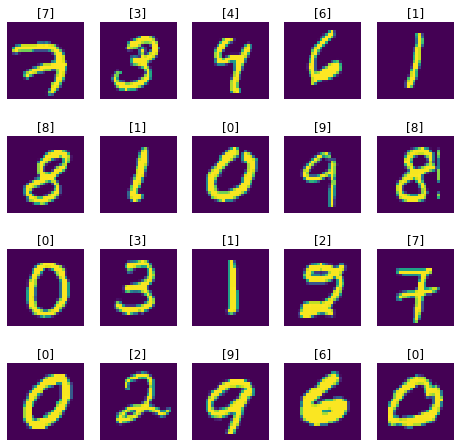

In [3]:
plt.figure(figsize=(8, 8))
for idx in range(20):
    plt.subplot(4, 5, idx+1)
    plt.axis('off')
    # np.argmax()返回最大索引值
    plt.title("[{}]".format(np.argmax(mnist.train.labels[idx])))
    plt.imshow(mnist.train.images[idx].reshape(28, 28))

接下来，定义用于训练的网络，首先定义网络的输入。

这里我们直接使用上面的数据作为输入，所以定义两个placeholder分别用于图像和lable数据，另外，定义一个bool类型的变量用于标识当前网络是否正在训练。

为了让网络更高效的运行，多个数据会被组织成一个batch送入网络，两个placeholder的第一个维度就是batchsize，因为我们这里还没有确定batchsize，所以第一个维度留空。

> **placeholder()函数是在神经网络构建graph的时候在模型中的占位，此时并没有把要输入的数据传入模型，它只会分配必要的内存。等建立session，在会话中，运行模型的时候通过feed_dict()函数向占位符喂入数据**

In [4]:
# 28*28 = 784，二维图像被拉抻成一维数组
x = tf.placeholder(tf.float32, [None, 784], name='x')
y = tf.placeholder(tf.float32, [None, 10], name='y')

因为我们输入的是图片展开后的一维向量，所以第一步就需要先把一维向量还原为二维的图片。

In [5]:
'''
[-1, 28, 28, 1]: 
-1: 表示未知具体个数，即不知道要有多少个图片，到时候通过自动计算进行赋值
28, 28: 表示一张图片中x, y轴的像素数
1: 表示满足28*28就是一张图片
'''
x_image = tf.reshape(x, [-1, 28, 28, 1])

接下来，我们定义第一个卷积层，使用6个5X5的卷积核对输入数据进行卷积，padding方式选择valid，所以输出数据的宽高变为24x24,但是深度已经从原来的1变成了6，本层卷积的激活函数为relu。 

**在tensorflow的整个结构中常常需要对变量或者对象进行共享，以来减少代码，其中对象就包括了各种卷积层，池化层，全连接网络层等等，所以接下来的代码中就使用<code>name_scope</code>来进行声明一个层的同时，也进行了占位（<code>[variable_scope](https://www.cnblogs.com/MY0213/p/9208503.html)</code>也是基于同样的思路），另外使用了<code>with</code>语句**
> **1.在某个tf.name_scope()指定的区域中定义的所有对象及各种操作，他们的“name”属性上会增加该命名区的区域名，用以区别对象属于哪个区域；  
2.将不同的对象及操作放在由tf.name_scope()指定的区域中，便于在tensorboard中展示清晰的逻辑关系图，这点在复杂关系图中特别重要**  

> **With语句帮助上下文管理器对象实现了两个自动化的操作enter和exit，并充分考虑了异常情况。对于资源类对象（用完需要尽快释放）的使用，比如文件句柄、数据库连接等等，这无疑是一种简洁而完善的代码形式。**

In [6]:
with tf.name_scope("conv1"):
    C1 = slim.conv2d(
        x_image,    # 输入数据
        6,          # 6个卷积核
        [5, 5],     # 卷积核大小
        padding="VALID",    # 选择补齐方式，VALID / SAME
        activation_fn=tf.nn.relu    # 激活方式选择ReLU
    )

接下来进行stride为2的最大池化，池化后，输出深度不变，但是长宽减半，所以输出变成了12x12,深度6.

In [7]:
with tf.name_scope("pool1"):
    S2 = slim.max_pool2d(
        C1,     # 输入数据
        [2, 2], # 卷积核大小
        stride=[2, 2],  # [2, 2]是怎么移动的？
        padding="VALID"
    )

接下来，我们定义第二个卷积层，使用16个5X5的卷积核对输入数据进行卷积，
padding方式还是选择valid，输出8x8,深度为16，本层卷积的激活函数为relu。

In [8]:
with tf.name_scope("conv2"):
    C3 = slim.conv2d(
        S2,    # 输入数据
        16,         # 16个卷积核
        [5, 5],     # 卷积核大小
        padding="VALID",    # 选择补齐方式，VALID / SAME
        activation_fn=tf.nn.relu    # 激活方式选择ReLU
    )

再进行一次stride为2的最大池化，输出为4x4,深度16。

In [9]:
with tf.name_scope("pool2"):
    S4 = slim.max_pool2d(
        C3,         # 输入数据
        [2, 2],     # 卷积核大小
        stride=[2, 2],  # 移动步长
        padding="VALID"
    )   

池化后的数据是3维的，这里做一个拉平的操作，将3维数据展开到1维，然后送入两层全连接，全连接隐层中神经元个数分别为120，84。

In [10]:
with tf.name_scope("fc1"):
    S4_flat = slim.flatten(S4)
    C5 = slim.fully_connected(
        S4_flat,
        120,
        activation_fn=tf.nn.relu
    )

with tf.name_scope("fc2"):
    C6 = slim.fully_connected(
        C5,
        84,
        activation_fn=tf.nn.relu
    )

Instructions for updating:
Use keras.layers.flatten instead.


###### 对特征添加一个0.6的dropout，以40%的概率丢弃特征中的某些数据，
这样可以提高网络的推广能力，减少过拟合的可能性。

需要注意的是，dropout仅在训练的时候使用，验证的时候，需要关闭dropout，
所以验证时候的keep_prob是1.0。

dropout的输出最终送入一个隐层为10的全连接层，这个全连接层即为最后的分类器。

In [11]:
# 定义一个名为"keep_prod"的graph占位，用于dropout
with tf.name_scope("dropout"):
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    C6_drop = tf.nn.dropout(
        C6,
        keep_prob
    )

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
'''
问题：声明在C5和C6的slim.fully_connected()里120，84为神经元数目，为何在logits中10却为隐层数目？
'''
with tf.name_scope("fc3"):
    logits = tf.contrib.slim.fully_connected(
        C6_drop,
        10, # 经过十个全连接层的处理后，会输出对0到9十个数字的分类
        activation_fn=None  # 最后一层不需要激活函数，之后会用softmax处理，得出每种可能的概率
    )

接下来定义loss和用于优化网络的优化器。loss计算使用了softmax_cross_entropy_with_logits，这样做的好处是labels可以不用手动做one_hot省了一些麻烦。这里使用了sgd优化器，学习率为0.3。
> tf.nn.softmax_cross_entropy_with_logits（）函数已经过时 (deprecated)，它在TensorFlow未来的版本中将被去除。取而代之的是tf.nn.softmax_cross_entropy_with_logits_v2（）

- 定义交叉熵损失：对上一层输出未经激活的logits结果进行softmax激活，然后再计算交叉熵损失，先激活在计算，两步合为一步,最后进行reduce_mean，就得到交叉熵损失
>试试看，增大减小学习率，换个优化器再进行训练会发生什么。

In [13]:
cross_entripy_loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



从模型中取出训练权重，然后进行L2正则化操作，最后求和
> <code>tf.add_n([list])</code>: 求list中元素的累加和，列表里的元素可以是向量，矩阵等

In [14]:
'''
问题：语法没看懂，tf.nn.l2_loss(w)回车后接一个for循环？
解答：python高阶语法，列表推导式
'''
l2_loss = tf.add_n(
    [
        tf.nn.l2_loss(w) for w in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        # tf.get_collection('losses'):获取集合“losses”中的所有元素，生成一个列表并返回该列表
    ]
)

> <code>tf.summary.histogram()</code>将输入的一个任意大小和形状的张量压缩成一个由宽度和数量组成的直方图数据结构．假设输入$[0.5, 1.1, 1.3, 2.2, 2.9, 2.99]$，则可以创建三个bin，分别包含$0-1$之间/$1-2$之间/$2-3$之间的所有元素，即三个bin中的元素分别为$[0.5]／[1.1, 1.3]/[2.2, 2.9, 2.99]$．这样，通过可视化张量在不同时间点的直方图来显示某些分布随时间变化的情况．

In [15]:
# 这一部分是为了tensorboard做准备
for w in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
    print(w.name)
    tf.summary.histogram(w.name, w)

# 交叉熵损失和加权l2损失的相加之和
total_loss = cross_entripy_loss + 7e-5 * l2_loss

tf.summary.scalar('cross_entropy_loss', cross_entripy_loss)
tf.summary.scalar('l2_loss', l2_loss)
tf.summary.scalar('total_loss', total_loss)

Conv/weights:0
INFO:tensorflow:Summary name Conv/weights:0 is illegal; using Conv/weights_0 instead.
Conv/biases:0
INFO:tensorflow:Summary name Conv/biases:0 is illegal; using Conv/biases_0 instead.
Conv_1/weights:0
INFO:tensorflow:Summary name Conv_1/weights:0 is illegal; using Conv_1/weights_0 instead.
Conv_1/biases:0
INFO:tensorflow:Summary name Conv_1/biases:0 is illegal; using Conv_1/biases_0 instead.
fully_connected/weights:0
INFO:tensorflow:Summary name fully_connected/weights:0 is illegal; using fully_connected/weights_0 instead.
fully_connected/biases:0
INFO:tensorflow:Summary name fully_connected/biases:0 is illegal; using fully_connected/biases_0 instead.
fully_connected_1/weights:0
INFO:tensorflow:Summary name fully_connected_1/weights:0 is illegal; using fully_connected_1/weights_0 instead.
fully_connected_1/biases:0
INFO:tensorflow:Summary name fully_connected_1/biases:0 is illegal; using fully_connected_1/biases_0 instead.
fully_connected_2/weights:0
INFO:tensorflow:Summ

<tf.Tensor 'total_loss:0' shape=() dtype=string>

In [16]:
print(total_loss)

Tensor("add:0", shape=(), dtype=float32)


In [17]:
# 梯度下降优化器
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.3).minimize(total_loss)

需要注意的是，上面的网络，最后输出的是未经softmax的原始logits，而不是概率分布，
要想看到概率分布，还需要做一下softmax。

将输出的结果与正确结果进行对比，即可得到我们的网络输出结果的准确率。

In [18]:
pred = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

saver用于保存或恢复训练的模型。

In [19]:
# 55000*2=100*1100，将训练数据全部训练两遍，epoch=2
batch_size = 100
trainig_step = 1100

saver = tf.train.Saver()

以上定义的所有操作，均为计算图，也就是仅仅是定义了网络的结构，实际需要运行的话，还需要创建一个session，并将数据填入网络中。
> **merge_all 可以将所有summary全部保存到磁盘，以便tensorboard显示。如果没有特殊要求，一般用这一句就可一显示训练时的各种信息了**

> **tf.Session.run()函数返回值为fetches的执行结果。如果fetches是一个元素就返回一个值；若fetches是一个list，则返回list的值，若fetches是一个字典类型，则返回和fetches同keys的字典**

In [20]:
#每次运行merged，会从整个网络收集summary
merged = tf.summary.merge_all()

with tf.Session() as sess:
    writer = tf.summary.FileWriter("./zuoye/logs/",sess.graph)
    # 初始化
    sess.run(tf.global_variables_initializer())
    
    # 定义验证集和测试集
    validation_data = {
        # placeholder
        x: mnist.validation.images,
        y: mnist.validation.labels,
        keep_prob:1.0
    }
    test_data = {
        x: mnist.test.images,
        y: mnist.test.labels,
        keep_prob:1.0
    }
    # 训练过程
    for i in range(trainig_step):
        xs, ys = mnist.train.next_batch(batch_size)
        _, loss, rs = sess.run(
            [optimizer, cross_entripy_loss, merged],
            feed_dict={
                x:xs,
                y:ys,
                keep_prob:0.6
            }
        )
        # 写到磁盘，为了分析
        writer.add_summary(rs, i)
        
        # 每100次训练打印一次损失值与验证准确率
        if i>0 and i % 100 == 0:
            validate_accuracy = sess.run(accuracy, feed_dict=validation_data)
            print(
                "after %d training steps, the loss is %g, the validation accuracy is %g" % (i, loss, validate_accuracy)
            )
            saver.save(sess, "./zuoye/model.ckpt",global_step=i)
            
    print("the training is finish!")
    # 最终的测试准确率
    acc = sess.run(accuracy, feed_dict=test_data)
    print("the test accuracy is :", acc)

after 100 training steps, the loss is 0.382662, the validation accuracy is 0.8988
after 200 training steps, the loss is 0.31935, the validation accuracy is 0.9484
after 300 training steps, the loss is 0.242528, the validation accuracy is 0.9606
after 400 training steps, the loss is 0.249773, the validation accuracy is 0.9646
after 500 training steps, the loss is 0.120766, the validation accuracy is 0.969
after 600 training steps, the loss is 0.159676, the validation accuracy is 0.9732
Instructions for updating:
Use standard file APIs to delete files with this prefix.
after 700 training steps, the loss is 0.0496258, the validation accuracy is 0.9744
after 800 training steps, the loss is 0.0870623, the validation accuracy is 0.9758
after 900 training steps, the loss is 0.0869705, the validation accuracy is 0.9812
after 1000 training steps, the loss is 0.0673272, the validation accuracy is 0.97
the training is finish!
the test accuracy is : 0.9804


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./zuoye/model.ckpt-1000
1.0


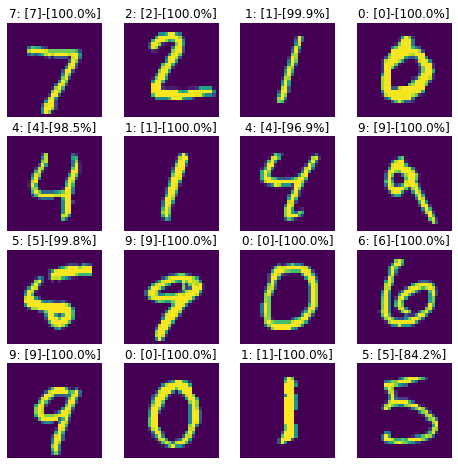

In [21]:
with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state('./zuoye/')
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        final_pred, acc =sess.run(
        [pred, accuracy],
        feed_dict={
            x: mnist.test.images[:16],  # 前16行数据导入给x
            y: mnist.test.labels[:16],
            keep_prob:1.0
        }) 
    orders = np.argsort(final_pred)  # 返回的是final_pred的大小排列的索引值的列表,这里的final_pred是softmax后的概率分布
    plt.figure(figsize = (8, 8))
    print(acc)
    for idx in range(16):
        order = orders[idx, :][-1] # 表示取第idx行数据的最后一个值，也就是概率最大的值的索引值
        prob = final_pred[idx, :][order]  # 对应的就是取到了这行数据中概率最大的概率值
        plt.subplot(4, 4, idx+1)
        plt.axis("off")
        plt.title('{}: [{}]-[{:.1f}%]'.format(np.argmax(mnist.test.labels[idx]),order, prob*100))
        plt.imshow(mnist.test.images[idx].reshape(28,28))
        
    else:
        pass